In [1]:
import pandas as pd
pd.set_option("display.max_rows", 300)
pd.set_option("display.max_columns", 100)

In [2]:
# Old script imports
from fta_data_cleaner import *
from dgs_data_cleaner import *
from tircp_data_cleaner import *

In [3]:
GCS_PATH = "gs://calitp-analytics-data/data-analyses/bus_procurement_cost/"

In [4]:
# All Raw Data
fta_raw = pd.read_csv(f"{GCS_PATH}raw_data-analyses_bus_procurement_cost_fta_press_release_data_csv.csv")
tirp_raw = pd.read_excel(f"{GCS_PATH}raw_TIRCP Tracking Sheets 2_1-10-2024.xlsx", sheet_name="Project Tracking")
dgs17b_raw = pd.read_excel(f"{GCS_PATH}raw_17b compiled.xlsx", sheet_name = "Usage Report Template")
dgs17c_raw = pd.read_excel(f"{GCS_PATH}raw_17c compiled-Proterra Compiled Contract Usage Report .xlsx", sheet_name = "Proterra ")

/opt/conda/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [5]:
# what does the final table look like again?
final = pd.read_parquet(f'{GCS_PATH}old/cpb_analysis_data_merge.parquet')

In [6]:
display(
    final.shape,
    final.sample(3)
)

(89, 11)

,transit_agency,project_title,prop_type,bus_size_type,description,new_project_type,total_cost,bus_count,source,ppno,project_description
54,VICTOR VALLEY TRANSIT AUTHORITY (VVTA),None,BEB,standard/conventional (30ft-45ft),None,None,4508160,5.0,dgs,1416,None
57,Alameda County Transit Authority,None,FCEB,standard/conventional (30ft-45ft),None,None,22846640,20.0,dgs,57071,None
81,Santa Maria Regional Transit,None,BEB,standard/conventional (30ft-45ft),None,None,5188379,5.0,dgs,63759,None


In [7]:
final['new_project_type'].value_counts()

bus only    52
Name: new_project_type, dtype: int64

In [8]:
final[final['new_project_type'] == "None"]

,transit_agency,project_title,prop_type,bus_size_type,description,new_project_type,total_cost,bus_count,source,ppno,project_description


# Scripts to Save
for new `bus_cost_utils.py` script

In [9]:
# NEW PROP FINDER
def new_prop_finder(description: str) -> str:
    """
    function that matches keywords from each propulsion type list against the item description col, returns a standardized prop type
    now includes variable that make description input lowercase.
    to be used with .assign()
    """

    BEB_list = [
        "battery electric",
        "BEBs paratransit buses"
    ]

    cng_list = [
        "cng",
        "compressed natural gas"    
    ]

    electric_list = [
        "electric buses",
        "electric commuter",
        "electric",
    ]

    FCEB_list = [
        "fuel cell",
        "hydrogen",
        #"fuel cell electric",
        #"hydrogen fuel cell",
        #"fuel cell electric bus",
        #"hydrogen electric bus",
    ]

    # low emission (hybrid)
    hybrid_list = [
        #"diesel electric hybrids",
        #"diesel-electric hybrids",
        #"hybrid electric",
        #"hybrid electric buses",
        #"hybrid electrics",
        "hybrids",
        "hybrid",
    ]

    # low emission (propane)
    propane_list = [
        #"propane buses",
        #"propaned powered vehicles",
        "propane",
    ]

    mix_beb_list = [
        "2 BEBs and 4 hydrogen fuel cell buses",
    ]

    mix_lowe_list = [
        "diesel and gas",
    ]

    mix_zero_low_list = [
        "15 electic, 16 hybrid",
        "4 fuel cell / 3 CNG",
        "estimated-cutaway vans (PM- award will not fund 68 buses",
        "1:CNGbus ;2 cutaway CNG buses",
    ]

    zero_e_list = [
        #"zero emission buses",
        #"zero emission electric",
        #"zero emission vehicles",
        "zero-emission",
        "zero emission",
    ]

    item_description = description.lower().replace("‐", " ").strip()

    if any(word in item_description for word in BEB_list) and not any(
        word in item_description for word in ["diesel", "hybrid", "fuel cell"]
    ):
        return "BEB"

    elif any(word in item_description for word in FCEB_list):
        return "FCEB"

    elif any(word in item_description for word in hybrid_list):
        return "low emission (hybrid)"

    elif any(word in item_description for word in mix_beb_list):
        return "mix (BEB and FCEB)"

    elif any(word in item_description for word in mix_lowe_list):
        return "mix (low emission)"

    elif any(word in item_description for word in mix_zero_low_list):
        return "mix (zero and low emission)"

    elif any(word in item_description for word in zero_e_list):
        return "zero-emission bus (not specified)"

    elif any(word in item_description for word in propane_list):
        return "low emission (propane)"

    elif any(word in item_description for word in electric_list):
        return "electric (not specified)"
    
    elif any(word in item_description for word in cng_list):
        return "CNG"

    else:
        return "not specified"

In [10]:
def new_bus_size_finder(description: str) -> str:
    """
    Similar to prop_type_find, matches keywords to item description col and return standardized bus size type.
    now includes variable that make description input lowercase.
    To be used with .assign()
    """

    articulated_list = [
        "60 foot",
        "articulated",
    ]

    standard_bus_list = [
        "30 foot",
        "35 foot",
        "40 foot",
        "40ft",
        "45 foot",
        "standard",
    ]

    cutaway_list = [
        "cutaway",
    ]

    other_bus_size_list = ["feeder bus"]

    otr_bus_list = [
        "coach style",
        "over the road",
    ]

    item_description = description.lower().replace("-", " ").strip()

    if any(word in item_description for word in articulated_list):
        return "articulated"

    elif any(word in item_description for word in standard_bus_list):
        return "standard/conventional (30ft-45ft)"

    elif any(word in item_description for word in cutaway_list):
        return "cutaway"

    elif any(word in item_description for word in otr_bus_list):
        return "over-the-road"

    elif any(word in item_description for word in other_bus_size_list):
        return "other"

    else:
        return "not specified"

In [11]:
def project_type_finder(description: str) -> str:
    """
    function to match keywords to project description col to identify projects that only have bus procurement.
    used to identify projects into diffferent categories: bus only, bus + others, no bus procurement.
    use with .assign() to get a new col.
    """
    bus_list =[
        "bus",
        "transit vehicles",# for fta list
        "cutaway vehicles",# for fta list
        "zero-emission vehicles", # for tircp list
        "zero emission vehicles",
        "zero‐emissions vans",
        "hybrid-electric vehicles",
        "battery-electric vehicles",
        "buy new replacement vehicles", # specific string for fta list
    ]
    
    exclude_list =[
        "facility",
        #"station",
        "stops",
        "installation",
        "depot",
        "construct",
        "infrastructure",
        "signal priority",
        "improvements",
        "build",
        "chargers",
        "charging equipment",
        "install",
        "rail",
        "garage",
        "facilities",
        "bus washing system",
        "build a regional transit hub" # specific string needed for fta list
        #"associated infrastructure" may need to look at what is associated infrastructure is for ZEB 
        
    ]
    proj_description = description.lower().strip()

    if any(word in proj_description for word in bus_list) and not any(
        word in proj_description for word in exclude_list
    ):
        return "bus only"
    
    elif any(word in proj_description for word in exclude_list) and not any(
        word in proj_description for word in bus_list
    ):
        return "non-bus components"
    
    elif any(word in proj_description for word in exclude_list) and any(
        word in proj_description for word in bus_list
    ):
        return "includes bus and non-bus components"
    
    else:
        return "needs review"

In [12]:
def col_row_updater(df: pd.DataFrame, col1: str, val1, col2: str, new_val):
    """
    function used to update values at specificed columns and row value.
    """
    df.loc[df[col1] == val1, col2] = new_val
    
    return

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

def dist_curve(
    df: pd.DataFrame,
    mean: str,
    std: str,
    title: str,
    xlabel: str,
):
    """
    function to make distribution curve. uses the "cpb" column of the df.
    """
    sns.histplot(df["cost_per_bus"], kde=True, color="skyblue", bins=20)
    # mean line
    plt.axvline(
        mean, color="red", linestyle="dashed", linewidth=2, label=f"Mean: ${mean:,.2f}"
    )
    # mean+1std
    plt.axvline(
        mean + std,
        color="green",
        linestyle="dashed",
        linewidth=2,
        label=f"Standard Deviation: ${std:,.2f}",
    )
    plt.axvline(mean - std, color="green", linestyle="dashed", linewidth=2)
    plt.axvline(mean + (std * 2), color="green", linestyle="dashed", linewidth=2)
    plt.axvline(mean + (std * 3), color="green", linestyle="dashed", linewidth=2)

    plt.title(title + " with Mean and Standard Deviation")
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")

    # Turn off scientific notation on x-axis?
    plt.gca().xaxis.set_major_formatter(ScalarFormatter(useMathText=False))

    plt.legend()
    plt.show()

    return

def make_chart(y_col: str, title: str, data: pd.DataFrame, x_col: str):
    """
    function to create chart. sorts values by y_col ascending."""
    
    data.sort_values(by=y_col, ascending=False).head(10).plot(
        x=x_col, y=y_col, kind="bar", color="skyblue"
    )
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)

    plt.ticklabel_format(style="plain", axis="y")
    plt.show()

# Chagnes to current grant type scripts


In [13]:
# FTA
import numpy as np
import pandas as pd
import shared_utils
from calitp_data_analysis.sql import to_snakecase
from bus_cost_utils import *
# from dgs_data_cleaner import new_bus_size_finder, new_prop_finder, project_type_checker
#from tircp_data_cleaner import col_row_updater

def col_splitter(
    df: pd.DataFrame, 
    col_to_split: str, 
    new_col1: str, 
    new_col2: str, 
    split_char: str
)-> pd.DataFrame:
    """
    function to split a column into 2 columns by specific character.
    ex. split 100(beb) to "100" & "(beb)"
    """
    df[[new_col1, new_col2]] = df[col_to_split].str.split(
        pat=split_char, n=1, expand=True
    )

    df[new_col2] = df[new_col2].str.replace(")", "")

    return df

def fta_agg_bus_only(df: pd.DataFrame) -> pd.DataFrame:
    """
    filters FTA data to only show projects with bus procurement (bus count > 0).
    then filters projects for new_project_type = bus only
    then aggregates
    """
    df1 = df[(df["bus_count"] > 0) & (df["new_project_type"] == "bus only")]

    df2 = (
        df1.groupby(
            [
                "project_sponsor",
                "project_title",
                "new_prop_type_finder",
                "new_bus_size_type",
                "description",
                "new_project_type"
            ]
        )
        .agg(
            {
                "funding": "sum",
                "bus_count": "sum",
            }
        )
        .reset_index()
    )

    return df2

def clean_fta_columns() -> pd.DataFrame:
    """
    Main function to clean FTA data. Reads in data, changes datatypes, change specific values.
    """
    # params
    
    file = "raw_data-analyses_bus_procurement_cost_fta_press_release_data_csv.csv"

    # read in data
    df = pd.read_csv(f"{gcs_path}{file}")

    # snakecase df
    df = to_snakecase(df)

    # clean funding values
    df["funding"] = (
        df["funding"]
        .str.replace("$", "")
        .str.replace(",", "")
        .str.strip()
    )

    # rename initial propulsion type col to propulsion category
    df = df.rename(columns={"propulsion_type": "prosulsion_category"})

    # splittign `approx_#_of_buses col to get bus count
    df1 = col_splitter(df, "approx_#_of_buses", "bus_count", "extract_prop_type", "(")

    # assign new columns via new_prop_finder and new_bus_size_finder
    df2 = df1.assign(
        new_prop_type_finder=df1["description"].apply(new_prop_finder),
        new_bus_size_type=df1["description"].apply(new_bus_size_finder),
        new_project_type=df1["description"].apply(project_type_checker)
    )

    # cleaning specific values
    col_row_updater(df2, "funding", "7443765", "bus_count", 56)
    col_row_updater(df2, "funding", "17532900", "bus_count", 12)
    col_row_updater(df2, "funding", "40402548", "new_prop_type_finder", "CNG")
    col_row_updater(df2, "funding", "30890413", "new_prop_type_finder", "mix (zero and low emission)")
    col_row_updater(df2, "funding", "29331665", "new_prop_type_finder", "mix (zero and low emission)")
    col_row_updater(df2, "funding", "7598425", "new_prop_type_finder", "mix (zero and low emission)")
    col_row_updater(df2, "funding", "7443765", "new_prop_type_finder", "mix (zero and low emission)")
    col_row_updater(df2, "funding", "3303600", "new_prop_type_finder", "mix (diesel and gas)")
    col_row_updater(df2, "funding", "2063160", "new_prop_type_finder", "low emission (hybrid)")
    col_row_updater(df2, "funding", "1760000", "new_prop_type_finder", "low emission (propane)")
    col_row_updater(df2, "funding", "1006750", "new_prop_type_finder", "ethanol")
    col_row_updater(df2, "funding", "723171", "new_prop_type_finder", "low emission (propane)")
    col_row_updater(df2, "funding", "23280546", "new_prop_type_finder", "BEB")

    # update data types
    update_cols = ["funding", "bus_count"]

    df2[update_cols] = df2[update_cols].astype("int64")

    return df2

#if __name__ == "__main__":

    # initial df (all projects)
#    all_projects = clean_fta_columns()

    # projects with bus count > 0 only.
#    just_bus = fta_agg_bus_only(all_projects)

    # export both DFs
#    all_projects.to_parquet(f"{gcs_path}clean_fta_all_projects.parquet")
#    just_bus.to_parquet(f"{gcs_path}clean_fta_bus_only.parquet")

In [14]:
# TIRCP
import numpy as np
import pandas as pd
import shared_utils
from calitp_data_analysis.sql import to_snakecase
from bus_cost_utils import *

def clean_tircp_columns() -> pd.DataFrame:
    """
    main function that reads in and cleans TIRCP data.
    """
    from fta_data_cleaner import gcs_path
    file_name = "raw_TIRCP Tracking Sheets 2_1-10-2024.xlsx"
    tircp_name = "Project Tracking"

    # read in data
    df = pd.read_excel(f"{gcs_path}{file_name}", sheet_name=tircp_name)

    # keep specific columns
    keep_col = [
        "Award Year",
        "Project #",
        "Grant Recipient",
        "Project Title",
        "PPNO",
        "District",
        "County",
        "Project Description",
        "bus_count",
        "Master Agreement Number",
        "Total Project Cost",
        "TIRCP Award Amount ($)",
    ]

    df1 = df[keep_col]

    # snakecase
    df2 = to_snakecase(df1)

    # dict of replacement values
    value_replace_dict = {
        "Antelope Valley Transit Authority ": "Antelope Valley Transit Authority (AVTA)",
        "Humboldt Transit Authority": "Humboldt Transit Authority (HTA)",
        "Orange County Transportation Authority": "Orange County Transportation Authority (OCTA)",
        "Capitol Corridor Joint Powers Authority": "Capitol Corridor Joint Powers Authority (CCJPA)",
        "Los Angeles County Metropolitan Transportation Authority": "Los Angeles County Metropolitan Transportation Authority (LA Metro)",
        "Monterey-Salinas Transit": "Monterey-Salinas Transit District (MST)",
        "Sacramento Regional Transit (SacRT)": "Sacramento Regional Transit District (SacRT)",
        "Sacramento Regional Transit District": "Sacramento Regional Transit District (SacRT)",
        "Sacramento Regional Transit District (SacRT) ": "Sacramento Regional Transit District (SacRT)",
        "San Diego Association of Governments": "San Diego Association of Governments (SANDAG)",
        "Santa Clara Valley Transportation Authority (SCVTA)": "Santa Clara Valley Transportation Authority (VTA)",
        "Southern California  Regional Rail Authority (SCRRA)": "Southern California Regional Rail Authority (SCRRA - Metrolink)",
        "Southern California Regional Rail Authority": "Southern California Regional Rail Authority (SCRRA - Metrolink)",
        "3, 4": "VAR",
    }
    
    # replacing values in agency & county col
    df3 = df2.replace(
        {"grant_recipient": value_replace_dict}
    ).replace(
        {"county": value_replace_dict}
    )
    
    # using update function to update values at specific columns and rows
    col_row_updater(df3, 'ppno', 'CP106', 'bus_count', 42)
    col_row_updater(df3, 'ppno', 'CP005', 'bus_count', 29)
    col_row_updater(df3, 'ppno', 'CP028', 'bus_count', 12)
    col_row_updater(df3, 'ppno', 'CP048', 'bus_count', 5)
    col_row_updater(df3, 'ppno', 'CP096', 'bus_count', 6)
    col_row_updater(df3, 'ppno', 'CP111', 'bus_count', 5)
    col_row_updater(df3, 'ppno', 'CP130', 'bus_count', 7)
    col_row_updater(df3, 'total_project_cost', 203651000, 'bus_count', 8)
    
    # columns to change dtype to str
    dtype_update = [
        'ppno',
        'district'
    ]
    
    df3[dtype_update] = df3[dtype_update].astype('str')
    
    # assigning new columns using imported functions.
    df4 = df3.assign(
        prop_type = df3['project_description'].apply(new_prop_finder),
        bus_size_type = df3['project_description'].apply(new_bus_size_finder),
        new_project_type  = df3['project_description'].apply(project_type_checker)
    )

    return df4

def tircp_agg_bus_only(df: pd.DataFrame) -> pd.DataFrame:
    """
    filters df to only include projects with bus procurement and for project type = bus only 
    does not include engineering, planning or construction only projects.
    then, aggregates the df by agency name and ppno. Agencies may have multiple projects that procure different types of buses
    """
    df2 = df[
        (df["bus_count"] > 0) & (df["new_project_type"] == "bus only")
    ]
    
    df3 = (
        df2.groupby(
            [
                "grant_recipient",
                "ppno",
                "prop_type",
                "bus_size_type",
                "project_description",
                "new_project_type"
            ]
        )
        .agg({"total_project_cost": "sum", "bus_count": "sum"})
        .reset_index()
    )
    return df3

#if __name__ == "__main__":
    
    
    
    # initial df
#    df1 = clean_tircp_columns()
    
    # aggregate 
#    df2 = tircp_agg_bus_only(df1)
    
    # export both df's as parquets to GCS
#    df1.to_parquet(f'{gcs_path}clean_tircp_all_project.parquet')
#    df2.to_parquet(f'{gcs_path}clean_tircp_bus_only_clean.parquet')

In [15]:
# DGS
import numpy as np
import pandas as pd
import shared_utils
from calitp_data_analysis.sql import to_snakecase
from bus_cost_utils import *

def calculate_total_cost(row):
    """
    Calculate new column for total cost by checking if total_with_options_per_unit is present or not.
    if not, then calculate using contract_unit_price.
    to be used with .assign()
    """
    if row["total_with_options_per_unit"] > 0:
        return row["total_with_options_per_unit"] * row["quantity"]
    else:
        return row["contract_unit_price"] * row["quantity"]
    
def clean_dgs_columns() -> pd.DataFrame:
    """
    reads in 2 dgs sheets, adds source column, merges both DFs, snakecase columns, update dtypes for monetary columns.
    merged first becaues the snakecase function messes with the dtypes for some reason
    """
    
    from fta_data_cleaner import gcs_path
    
    # params
    file_17c = "raw_17c compiled-Proterra Compiled Contract Usage Report .xlsx"
    file_17b = "raw_17b compiled.xlsx"
    sheet_17c = "Proterra "
    sheet_17b = "Usage Report Template"

    # merge columns for dataframes
    merge_col = [
        "Agency Billing Code",
        "Contract Line Item Number (CLIN)                (RFP ID)",
        "Contract Unit Price",
        "Delivery Date",
        "Extended Contract Price Paid",
        "Index Date / Catalog Version",
        "Item Description",
        "List Price/MSRP",
        "Manufacturer (OEM)",
        "Manufacturer Part Number (OEM #)",
        "Ordering Agency Name",
        "Purchase Order Date",
        "Purchase Order Number",
        "Purchasing Authority Number                    (for State departments)",
        "Quantity in \nUnit of Measure\n",
        "Quantity",
        "source",
        "State (S) or Local (L) agency",
        "Unit of Measure",
        "UNSPSC Code\n(Version 10)",
        "Supplier Contract Usage ID",
    ]

    # columns to change dtype
    to_int64 = [
        "contract_unit_price",
        "extended_contract_price_paid",
        "total_with_options_per_unit",
        "grand_total",
    ]
    
    # read in data
    dgs_17c = pd.read_excel(f"{gcs_path}{file_17c}", sheet_name=sheet_17c)
    dgs_17b = pd.read_excel(f"{gcs_path}{file_17b}", sheet_name=sheet_17b)

    # add new column to identify source
    dgs_17c["source"] = "17c"
    dgs_17b["source"] = "17b"

    # merge
    dgs_17bc = pd.merge(dgs_17b, dgs_17c, how="outer", on=merge_col).fillna(0)

    # snakecase
    dgs_17bc = to_snakecase(dgs_17bc)

    # takes list of columns and updates to int64
    dgs_17bc[to_int64] = dgs_17bc[to_int64].astype("int64")

    # change purchase_order_number col to str
    dgs_17bc["purchase_order_number"] = dgs_17bc["purchase_order_number"].astype("str")

    # adds 3 new columns from functions
    dgs_17bc2 = dgs_17bc.assign(
        total_cost=dgs_17bc.apply(calculate_total_cost, axis=1),
        new_prop_type=dgs_17bc["item_description"].apply(new_prop_finder),
        new_bus_size=dgs_17bc["item_description"].apply(new_bus_size_finder),
    )

    return dgs_17bc2

def dgs_agg_by_agency(df: pd.DataFrame) -> pd.DataFrame:
    """
    function that aggregates the DGS data frame by transit agency and purchase order number (PPNO) to get total cost of just buses without options.
    first, dataframe is filtered for rows containing buses (does not include rows with 'not specified').
    then, group by agency, PPNO, prop type and bus size. and aggregate the quanity and total cost of just buses.
    Possible for agencies to have multiple PPNOs for different bus types and sizes.
    """
    # filter for rows containing bus, does not include accessories/warranties/parts/etc.
    agg_agency_bus_count = df[~df["new_prop_type"].str.contains("not specified")]

    agg_agency_bus_count2 = agg_agency_bus_count[
        [
            "ordering_agency_name",
            "purchase_order_number",
            "item_description",
            "quantity",
            "source",
            "total_cost",
            "new_prop_type",
            "new_bus_size",
        ]
    ]

    agg_agency_bus_count3 = (
        agg_agency_bus_count2.groupby(
            [
                "ordering_agency_name",
                "purchase_order_number",
                "new_prop_type",
                "new_bus_size",
            ]
        )
        .agg(
            {
                "quantity": "sum",
                "total_cost": "sum",
                "source": "max",
            }
        )
        .reset_index()
    )

    return agg_agency_bus_count3

def dgs_agg_by_agency_w_options(df: pd.DataFrame) -> pd.DataFrame:
    """
    similar to the previous function, aggregates the DGS dataframe by transit agency to get total cost of buses with options.
    agencies may order buses with different configurations, resulting in different total cost.
    function creates 1 df of only buses to retain initial proulsion type, size type and quanity of buses.
    then, creates 2nd df of aggregated total cost of buses+options, by transit agency.
    lastly, both df's are merged together.
    """
    # filter df for rows NOT containing 'not specified'. only returns rows with buses
    dfa = df[~df["new_prop_type"].str.contains("not specified")]

    # keep specific columns
    df2 = dfa[
        [
            "ordering_agency_name",
            "purchase_order_number",
            "quantity",
            "new_prop_type",
            "new_bus_size",
            "source",
        ]
    ]

    # aggregate by agency and PPNO, get total cost of buses with options
    df3 = (
        df.groupby(["ordering_agency_name", "purchase_order_number"])
        .agg({"total_cost": "sum"})
        .reset_index()
    )

    # merge both dataframes on agency and PPNO to get bus only rows & total cost with options.
    merge = pd.merge(
        df2, df3, on=["ordering_agency_name", "purchase_order_number"], how="left"
    )

    return merge

#if __name__ == "__main__":
    

    # initial df
#    df1 = clean_dgs_columns()
    
    #df of just bus cost (no options)
#    just_bus = dgs_agg_by_agency(df1)
    
    #df of bus cost+options
#    bus_w_options = dgs_agg_by_agency_w_options(df1)
    
    #export serperate df's as parquet to GCS
#    just_bus.to_parquet(f'{gcs_path}clean_dgs_all_projects.parquet')
#    bus_w_options.to_parquet(f'{gcs_path}clean_dgs_bus_only_w_options.parquet')

In [16]:
# cost per bus cleaner
# rename to all_bus_cost_cleaner?

import pandas as pd
from bus_cost_utils import *
from scipy.stats import zscore

def outlier_flag(col):
    """
    function to flag outlier rows. use with .apply()
    """
    
    return col <= -3 or col >= 3

def prepare_all_data() ->pd.DataFrame:
    """
    primary function to read-in, merge data across FTA, TIRCP and DGS data.
    standardizes columns names, then exports as parquet.
    """
    # variables for file names


    
    # dictionary to update columns names 
    col_dict = {
        "funding": "total_cost",
        "grant_recipient": "transit_agency",
        "new_bus_size": "bus_size_type",
        "new_bus_size_type": "bus_size_type",
        "new_prop_type": "prop_type",
        "new_prop_type_finder": "prop_type",
        "ordering_agency_name": "transit_agency",
        "purchase_order_number": "ppno",
        "quantity": "bus_count",
        "total_project_cost": "total_cost",
        "project_sponsor": "transit_agency",
    }

    # reading in data
    # bus only projects for each datase
    fta = pd.read_parquet(f"{gcs_path}clean_fta_bus_only.parquet")
    tircp = pd.read_parquet(f"{gcs_path}clean_tircp_bus_only_clean.parquet")
    dgs = pd.read_parquet(f"{gcs_path}clean_dgs_bus_only_w_options.parquet")
    
    # adding new column to identify source
    fta["source"] = "fta"
    tircp["source"] = "tircp"
    dgs["source"] = "dgs"

    # using .replace() with dictionary to update column names
    fta2 = fta.rename(columns=col_dict)
    tircp2 = tircp.rename(columns=col_dict)
    dgs2 = dgs.rename(columns=col_dict)
    
    # merging fta2 and tircp 2
    merge1 = pd.merge(fta2,
        tircp2,
        on=[
            "transit_agency",
            "prop_type",
            "bus_size_type",
            "total_cost",
            "bus_count",
            "source",
            "new_project_type"
        ],
        how="outer",
    )
    
    # mergeing merge1 and dgs2
    merge2 = pd.merge(merge1,
        dgs2,
        on=[
            "transit_agency",
            "prop_type",
            "bus_size_type",
            "total_cost",
            "bus_count",
            "source",
            "ppno",
        ],
        how="outer",
    )
    #normalizing data with cost per bus
    #calculating cost per bus here
    merge2["cost_per_bus"] = (merge2["total_cost"] / merge2["bus_count"]).astype("int64")
    
    #calculating zscore on cost per bus
    merge2["zscore_cost_per_bus"] = zscore(merge2["cost_per_bus"])
    #flag any outliers
    merge2["is_cpb_outlier?"] = merge2["zscore_cost_per_bus"].apply(outlier_flag)
    return merge2



def new_cpb_aggregate(df: pd.DataFrame, column="transit_agency") -> pd.DataFrame:
    """
    function to aggregate compiled data by different categories:
        "transit agency", 
        "propulsion type", 
        "bus_size_type",
        "new_project_type"
    aggregate on columns:
        "project_title"
        "ppno"
        "total_cost"
        "bus_count"
        
    Then, cost per bus is calculated AFTER the aggregation.
    """
    df_agg = (
        df.groupby(column)
        .agg(
            total_project_count=("project_title", "count"),
            total_project_count_ppno=("ppno", "count"),
            total_agg_cost=("total_cost", "sum"),
            total_bus_count=("bus_count", "sum"),
            #new_prop_type=("prop_type","max")
        )
        .reset_index()
    )
    df_agg["new_cost_per_bus"] = (df_agg["total_agg_cost"] / df_agg["total_bus_count"]).astype("int64")
    
    #calculate zscore
    df_agg["new_zscore_cost_per_bus"] = zscore(df_agg["new_cost_per_bus"])
    
    #flag outliers
    df_agg["new_is_cpb_outlier?"] = df_agg["new_zscore_cost_per_bus"].apply(outlier_flag)
    
    return df_agg



#if __name__ == "__main__":
    
    # initial df
#    df1 = prepare_all_data()
    #remove outliers based on cost per bus zscore
#    df2 = df1[df1["is_cpb_outlier?"]==False]
    
    # export to gcs
#    df1.to_parquet(f'{gcs_path}cleaned_cpb_analysis_data_merge.parquet')
#    df2.to_parquet(f'{gcs_path}cleaned_no_outliers_cpb_analysis_data_merge.parquet')

In [17]:
# find outliers 
find_outliers = pd.read_parquet(f'{GCS_PATH}cleaned_cpb_analysis_data_merge.parquet')

In [18]:
display(
    len(find_outliers),
    len(find_outliers[find_outliers["is_cpb_outlier?"]==True]),
    find_outliers[find_outliers["is_cpb_outlier?"]==True],
    find_outliers[find_outliers["transit_agency"].str.contains("Merced County")]
)

89

1

,transit_agency,project_title,prop_type,bus_size_type,description,new_project_type,total_cost,bus_count,source,ppno,project_description,cost_per_bus,zscore_cost_per_bus,is_cpb_outlier?
84,Transit Joint Powers Authority for Merced County,None,BEB,standard/conventional (30ft-45ft),None,None,3223324,1.0,dgs,EBUS002,None,3223324,5.130048,True


,transit_agency,project_title,prop_type,bus_size_type,description,new_project_type,total_cost,bus_count,source,ppno,project_description,cost_per_bus,zscore_cost_per_bus,is_cpb_outlier?
51,Transit Joint Powers Authority of Merced County,None,zero-emission bus (not specified),not specified,None,bus only,3696513,3.0,tircp,CP074,Purchases 3 zero-emission electric buses to in...,1232171,0.879900,False
83,Transit Joint Powers Authority for Merced County,None,BEB,standard/conventional (30ft-45ft),None,None,3223324,2.0,dgs,EBUS002,None,1611662,1.689929,False
84,Transit Joint Powers Authority for Merced County,None,BEB,standard/conventional (30ft-45ft),None,None,3223324,1.0,dgs,EBUS002,None,3223324,5.130048,True


# NB Variables rework
time to organize, cut down, consolidate variables

## Variable Categories
- initial DF stuff (all cleaned merged data)
 - all_bus
 - all_projecT_counter function

lots of total counts
**this can be solved by filtering the same df but its different grant type, or using a table of groupby grant type and count of projects**

 []count of all projects
- ~~all_project_count~~
- ~~total_bus_count~~
- ~~total_funding~~

 count of all projects for each grant type
- count_all_fta
- count_all_tircp
- count_all_dgs
 fix: use all_project_count to create a pivot table with margins of each grant type. margins should also add a grand total col
 
 []count of bus only projects
 - ~~bus_only_project_count~~ (this is in merged data)
 
 count of bus only projects for each grant type
 - ~~bus_only_count_fta~~
 - ~~bus_only_count_tircp~~
 - ~~bus_only_count_dgs~~
 fix: use all_project_count to create a summarized dataframe of each grant type

 
 
- ZEB only
    ~~- zeb_only_df function~~
    switched to filtering the dataframe to get ZEB answers

- non-ZEB only
    ~~- non_zeb_only_df function~~
    switched to filtering the dataframe
    
- means and standard deviations
    - for charts?


# Draft/Test cells

## Testing `new_cpb_aggregate` function against initial `cpb_appregate` function.
to make sure the core data matches, and expect the new function to provide zscores and outlier flags

In [19]:
# initial final df from old code
# 89 rows and 11 columns
display(
    final.shape,
    final.columns
)

(89, 11)

Index(['transit_agency', 'project_title', 'prop_type', 'bus_size_type',
       'description', 'new_project_type', 'total_cost', 'bus_count', 'source',
       'ppno', 'project_description'],
      dtype='object')

In [20]:
# making copy of final 
# test = final #THIS DOES NOT WORK! this is just assigning a new name to final
test = pd.read_parquet(f'{GCS_PATH}old/cpb_analysis_data_merge.parquet')

In [21]:
# testing the improved cpb agg function
# default grouby column is `transit_agency`

agg1 = new_cpb_aggregate(test)

In [22]:
# there are some duplicate agencies in the inial DF, these get aggregated together after using the function
# the resulting DF is shorter
display(
    final.shape,
    agg1.shape,
    final.columns,
    agg1.columns
)

(89, 11)

(82, 8)

Index(['transit_agency', 'project_title', 'prop_type', 'bus_size_type',
       'description', 'new_project_type', 'total_cost', 'bus_count', 'source',
       'ppno', 'project_description'],
      dtype='object')

Index(['transit_agency', 'total_project_count', 'total_project_count_ppno',
       'total_agg_cost', 'total_bus_count', 'new_cost_per_bus',
       'new_zscore_cost_per_bus', 'new_is_cpb_outlier?'],
      dtype='object')

In [23]:
# confirming the default cpb_agg is working
agg1.sample(3)

,transit_agency,total_project_count,total_project_count_ppno,total_agg_cost,total_bus_count,new_cost_per_bus,new_zscore_cost_per_bus,new_is_cpb_outlier?
45,Oregon Department of Transportation on behalf ...,1,0,181250,5.0,36250,-1.866706,False
63,South Dakota Department of Transportation on b...,1,0,1276628,9.0,141847,-1.603111,False
17,City of Santa Rosa(Santa Rosa CityBus),0,1,5987790,5.0,1197558,1.032193,False


In [79]:
# agg looks good
# double checked it against the old agg function, CPB numbers match between this new function and old one
display(
    final.shape,
    agg1.shape,
    agg1.head(),
    agg1["new_is_cpb_outlier?"].value_counts(),
    agg1["new_zscore_cost_per_bus"].min(),
    agg1["new_zscore_cost_per_bus"].max(),
    agg1[agg1["new_is_cpb_outlier?"] == True]
)

(89, 11)

(82, 8)

,transit_agency,total_project_count,total_project_count_ppno,total_agg_cost,total_bus_count,new_cost_per_bus,new_zscore_cost_per_bus,new_is_cpb_outlier?
0,AUTORIDAD METROPOLITANA DE AUTOBUSES (PRMBA),1,0,10000000,8.0,1250000,1.163100,False
1,Alameda County Transit Authority,0,1,22846640,20.0,1142332,0.894336,False
2,Antelope Valley Transit Authority (AVTA),0,1,39478000,29.0,1361310,1.440957,False
3,"CITY OF PORTERVILLE (PORTERVILLE, CA)",0,1,2781891,3.0,927297,0.357558,False
4,CULVER CITY TRANSPORTATION DEPARTMENT (CULVER ...,0,1,3623536,4.0,905884,0.304106,False


False    81
True      1
Name: new_is_cpb_outlier?, dtype: int64

-1.8667057821355477

3.4069219663792882

,transit_agency,total_project_count,total_project_count_ppno,total_agg_cost,total_bus_count,new_cost_per_bus,new_zscore_cost_per_bus,new_is_cpb_outlier?
71,Transit Joint Powers Authority for Merced County,0,2,6446648,3.0,2148882,3.406922,True


In [ ]:
# test to aggregate by other columns 
agg_prop_type = new_cpb_aggregate(test,"prop_type")

In [ ]:
# need to compare to the agg prob data in the report

from cost_per_bus_nb_scripts import cpb_aggregate, no_outliers

old_prop_agg = cpb_aggregate(no_outliers, "prop_type")

In [ ]:
#EVERYTHING CHECKS OUT!
display(
    old_prop_agg.shape,
    agg_prop_type.shape,
    old_prop_agg,
    agg_prop_type
)

In [ ]:
#EVERYTHING CHECKS OUT!
new_agg_bus_size = new_cpb_aggregate(test, "bus_size_type")
old_size_agg = cpb_aggregate(no_outliers, "bus_size_type")
display(
    old_size_agg.shape,
    new_agg_bus_size.shape,
    old_size_agg,
    new_agg_bus_size
)

In [ ]:
#EVERYTHING CHECKS OUT!
# move forward with `new_cpb_aggregate` function
new_agg_agency = new_cpb_aggregate(test)
old_agency_agg = cpb_aggregate(no_outliers, "transit_agency")
display(
    old_agency_agg.shape,
    new_agg_agency.shape,
    old_agency_agg,
    new_agg_agency
)

## Testing variables rework
there are a lot of variables in the initial script. need to cut down the amount of variables or at least make it more efficient. 

In [25]:
# read in all cleaned project data
# same as final from above
# cpb_analysis_data_merge is bus only projects. all DGS rows were Bus only projects anyways
merged_data = pd.read_parquet(f'{GCS_PATH}cleaned_no_outliers_cpb_analysis_data_merge.parquet')
merged_data.columns

Index(['transit_agency', 'project_title', 'prop_type', 'bus_size_type',
       'description', 'new_project_type', 'total_cost', 'bus_count', 'source',
       'ppno', 'project_description', 'cost_per_bus', 'zscore_cost_per_bus',
       'is_cpb_outlier?'],
      dtype='object')

In [73]:
# no outliers
# use new_cpb_aggregaete on merged data then filter for outliers == False
agg_agency = new_cpb_aggregate(merged_data)

agg_prop = new_cpb_aggregate(merged_data, column="prop_type")
agg_bus_size = new_cpb_aggregate(merged_data, column="bus_size_type")
agg_source = new_cpb_aggregate(merged_data, column="source")

#overall agency info
display(

    #min max, without outlier
    agg_agency["new_cost_per_bus"].agg(["max","min"]),
    agg_agency["total_bus_count"].agg(["max","min"]),
    agg_agency["total_agg_cost"].agg(["max","min"]),
    agg_agency["new_zscore_cost_per_bus"].agg(["max","min"]),
    
)

max    1611662
min      36250
Name: new_cost_per_bus, dtype: int64

max    160.0
min      1.0
Name: total_bus_count, dtype: float64

max    103000000
min       181250
Name: total_agg_cost, dtype: int64

max    2.182513
min   -1.939451
Name: new_zscore_cost_per_bus, dtype: float64

In [71]:
# testing pivot table on `merged_data`

#pivot table to get totals for each prop type
pivot_prop_type = pd.pivot_table(
    merged_data,
    values = ["bus_count", "total_cost"],
    index = "prop_type",
    aggfunc = "sum",
    margins = True,
    margins_name = "Grand Total"
)
display(
    #from new_cpb_agg
    agg_prop,
    #pivot
    #pivot_prop_type
)
# same data, dont need  the pivot table anymore

,prop_type,total_project_count,total_project_count_ppno,total_agg_cost,total_bus_count,new_cost_per_bus,new_zscore_cost_per_bus,new_is_cpb_outlier?
0,BEB,0,30,167232489,163.0,1025966,0.897727,False
1,CNG,12,1,176039140,252.0,698568,0.125652,False
2,FCEB,2,6,120951335,102.0,1185797,1.274642,False
3,electric (not specified),1,2,56678000,44.0,1288136,1.515980,False
4,ethanol,1,0,1006750,9.0,111861,-1.257929,False
5,low emission (hybrid),16,0,91824361,145.0,633271,-0.028332,False
6,low emission (propane),5,0,8403969,44.0,190999,-1.071304,False
7,mix (zero and low emission),2,0,36775430,125.0,294203,-0.827927,False
8,not specified,4,1,41552404,325.0,127853,-1.220216,False
9,zero-emission bus (not specified),0,5,128156513,143.0,896199,0.591708,False


In [116]:
#pivot table to get grand total for zeb only data

# keep this
zeb_list =[
    "BEB",
    "FCEB",
    "electric (not specified)",
    "zero-emission bus (not specified)",

]

#keep this
non_zeb_list =[
    "CNG",
    "ethanol",
    "low emission (hybrid)",
    "low emission (propane)",
    "mix (zero and low emission)",
]



#keep this
pivot_zeb_prop = pd.pivot_table(
    #filted incoming DF for zeb prop types
    merged_data[merged_data["prop_type"].isin(zeb_list)],
    values = ["bus_count", "total_cost"],
    index = "prop_type",
    aggfunc = "sum",
    margins = True,
    margins_name = "Grand Total"
).reset_index()              

#keep this
pivot_non_zeb_prop = pd.pivot_table(
    #filted incoming DF for non-zeb prop types
    merged_data[merged_data["prop_type"].isin(non_zeb_list)],
    values = ["bus_count", "total_cost"],
    index = "prop_type",
    aggfunc = "sum",
    margins = True,
    margins_name = "Grand Total"
).reset_index()

In [117]:
display(
    #zeb data 3 different methods
    #1. filtering agg_prop by zeb list, no grand totas
    #2. filtering pivot talbe by zeb list, without grand totals
    #3. dedicated pivot table for zeb, with grand totals
    #agg_prop[agg_prop["prop_type"].isin(zeb_list)],
    #pivot_prop_type.loc[zeb_list],
    pivot_zeb_prop,
    
    #non-zeb same 3 methods
    #agg_prop[agg_prop["prop_type"].isin(non_zeb_list)],
    #pivot_prop_type.loc[non_zeb_list],
    pivot_non_zeb_prop
)
# confirmed all data is the same, but need pivot for grand total rows

,prop_type,bus_count,total_cost
0,BEB,163.0,167232489
1,FCEB,102.0,120951335
2,electric (not specified),44.0,56678000
3,zero-emission bus (not specified),143.0,128156513
4,Grand Total,452.0,473018337


,prop_type,bus_count,total_cost
0,CNG,252.0,176039140
1,ethanol,9.0,1006750
2,low emission (hybrid),145.0,91824361
3,low emission (propane),44.0,8403969
4,mix (zero and low emission),125.0,36775430
5,Grand Total,575.0,314049650


In [31]:
# answers total buses and cost per grant type
pivot_size = pd.pivot_table(
    merged_data,
    values = ["bus_count", "total_cost"],
    index = "bus_size_type",
    aggfunc = "sum",
    margins = True,
    margins_name = "Grand Total"
)
display(
    agg_bus_size,
    #pivot_size
)

#same data, dont need pivot for this one because the grand totals will be the same. and the pivot tables dont have cpb

,bus_size_type,total_project_count,total_project_count_ppno,total_agg_cost,total_bus_count,new_cost_per_bus,new_zscore_cost_per_bus,new_is_cpb_outlier?
0,articulated,0,2,58237576,41.0,1420428,1.605005,False
1,cutaway,3,0,16694500,152.0,109832,-1.464878,False
2,not specified,40,6,509919038,881.0,578795,-0.366399,False
3,over-the-road,0,1,9516000,14.0,679714,-0.130011,False
4,standard/conventional (30ft-45ft),0,36,234253277,264.0,887323,0.356283,False


,bus_count,total_cost
bus_size_type,,
articulated,41.0,58237576
cutaway,152.0,16694500
not specified,881.0,509919038
over-the-road,14.0,9516000
standard/conventional (30ft-45ft),264.0,234253277
Grand Total,1352.0,828620391


In [123]:
# answers total buses and cost per grant type
pivot_source = pd.pivot_table(
    merged_data,
    values = ["bus_count", "total_cost"],
    index = "source",
    aggfunc = "sum",
    margins = True,
    margins_name = "Grand Total"
).reset_index()

display(
    agg_source,
    pivot_source
)
# dont need pivot, keep agg_source to retain cpb

,source,total_project_count,total_project_count_ppno,total_agg_cost,total_bus_count,new_cost_per_bus,new_zscore_cost_per_bus,new_is_cpb_outlier?
0,dgs,0,36,250112853,236.0,1059800,1.150152,False
1,fta,43,0,391257025,883.0,443099,-1.287721,False
2,tircp,0,9,187250513,233.0,803650,0.137569,False


,source,bus_count,total_cost
0,dgs,236.0,250112853
1,fta,883.0,391257025
2,tircp,233.0,187250513
3,Grand Total,1352.0,828620391


## Testing Charts

using `merged_data`, now without outliers.
charts looking good, similar results to initial charts

In [75]:
# means and standard deviations
# for graphs
cpb_mean = merged_data["cost_per_bus"].mean()
cpb_std = merged_data["cost_per_bus"].std()

display(
    cpb_mean,
    cpb_std
)

792635.3409090909

396712.6067531972

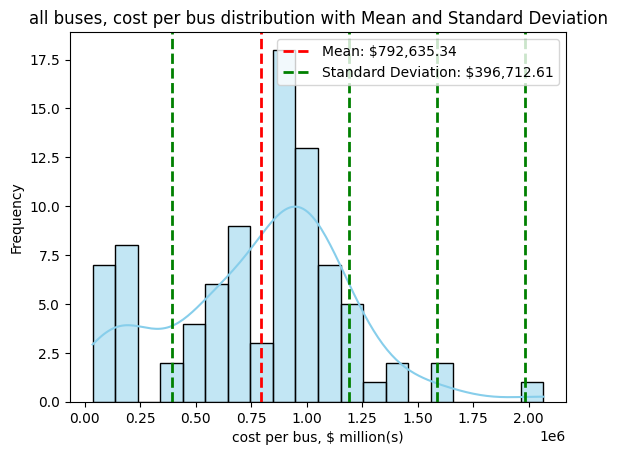

In [68]:
dist_curve(
    df=merged_data,
    mean=cpb_mean,
    std=cpb_std,
    title="all buses, cost per bus distribution",
    xlabel="cost per bus, $ million(s)",
)

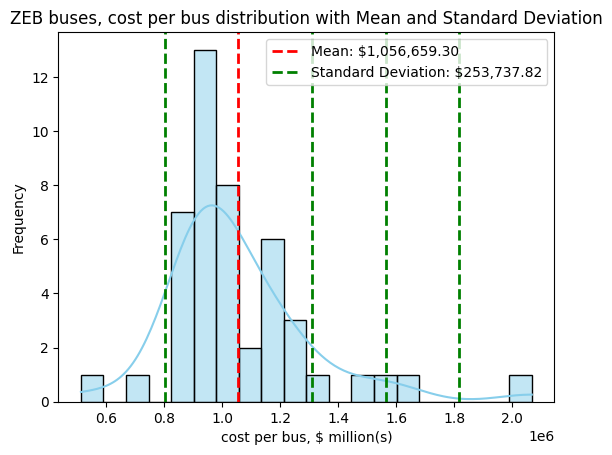

In [67]:
dist_curve(
    df=merged_data[merged_data["prop_type"].isin(zeb_list)],
    mean=merged_data[merged_data["prop_type"].isin(zeb_list)]["cost_per_bus"].mean(),
    std=merged_data[merged_data["prop_type"].isin(zeb_list)]["cost_per_bus"].std(),
    title="ZEB buses, cost per bus distribution",
    xlabel="cost per bus, $ million(s)",
)

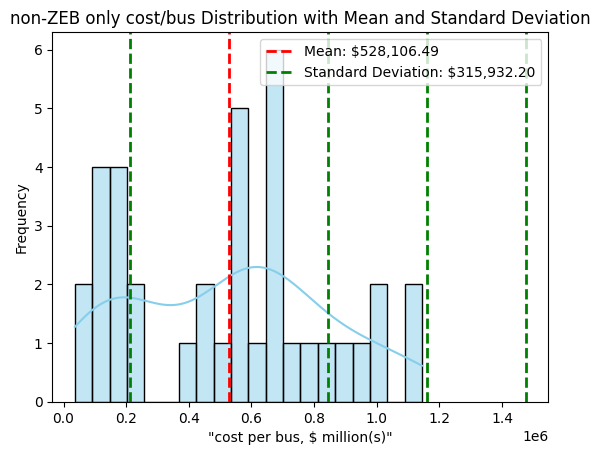

In [46]:

dist_curve(
    df=merged_data[merged_data["prop_type"].isin(non_zeb_list)],
    mean=merged_data[merged_data["prop_type"].isin(non_zeb_list)]["cost_per_bus"].mean(),
    std=merged_data[merged_data["prop_type"].isin(non_zeb_list)]["cost_per_bus"].std(),
    title="non-ZEB costper bus Distribution",
    xlabel='"cost per bus, $ million(s)"',
)

In [63]:
agg_prop.columns

Index(['prop_type', 'total_project_count', 'total_project_count_ppno',
       'total_agg_cost', 'total_bus_count', 'new_cost_per_bus',
       'new_zscore_cost_per_bus', 'new_is_cpb_outlier?'],
      dtype='object')

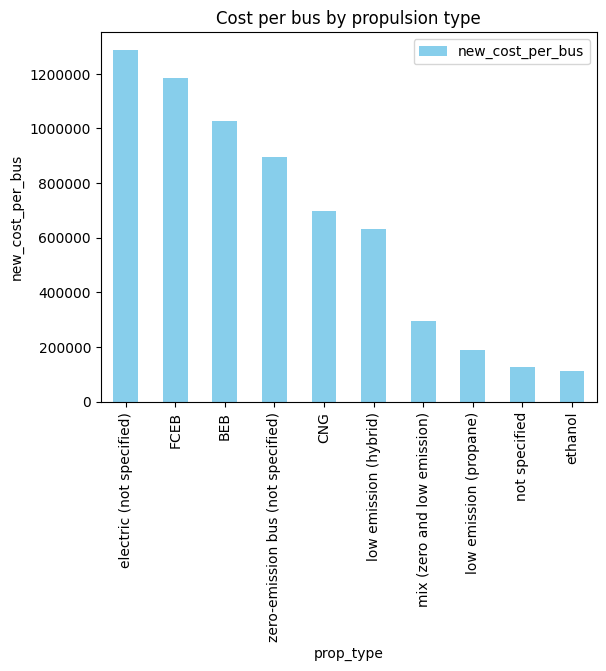

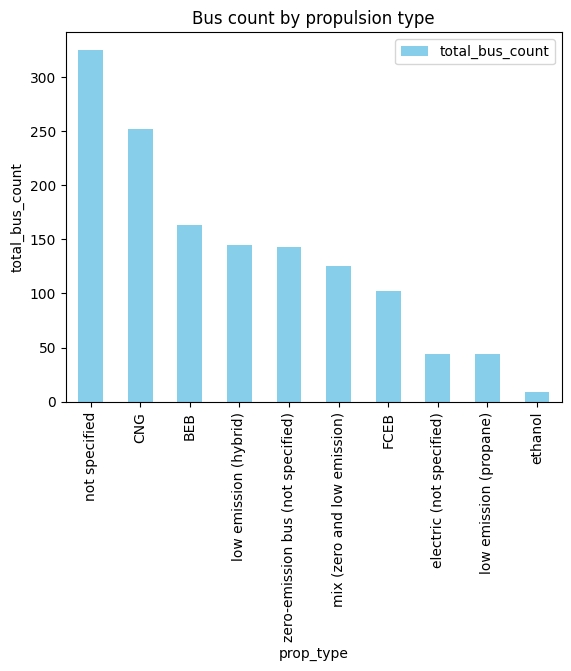

None

None

,prop_type,new_cost_per_bus,total_bus_count
3,electric (not specified),1288136,44.0
2,FCEB,1185797,102.0
0,BEB,1025966,163.0
9,zero-emission bus (not specified),896199,143.0
1,CNG,698568,252.0
5,low emission (hybrid),633271,145.0
7,mix (zero and low emission),294203,125.0
6,low emission (propane),190999,44.0
8,not specified,127853,325.0
4,ethanol,111861,9.0


In [66]:
display(
    make_chart("new_cost_per_bus", "Cost per bus by propulsion type", x_col="prop_type", data=agg_prop),
    make_chart("total_bus_count", "Bus count by propulsion type", x_col="prop_type", data=agg_prop),
    agg_prop[["prop_type","new_cost_per_bus","total_bus_count"]].sort_values(by="new_cost_per_bus", ascending=False)
)

## Testing summary
time to rework the summary section.

no more long expositions and variables. try to get the same point across using tables instead.

In [126]:
summary = f"""

# Bus Procurement Cost Analysis

## Summary
This analysis examines the cost of buses for transit agencies across the county. Specifically, to observe the variation of bus cost for propulsion type and bus sizes.

Data was compiled from three data sources:
    1. FTA Bus and Low- and No-Emission Grant Awards press release (federally funded, nationwide data)
    2. TIRCP project data (state-funded, California only)
    3. DGS usage report for all procurements from California agencies purchasing from New Flyer and Portera Inc.. 

Breakdown of each data souce:
{pivot_source.to_markdown(index=False)}

The initial dataset was contained close to 300 projects, but was paired down due to projects including components other than buses. Examples include: projects that constructed new facilities, trainings or other non-bus related items like trains and sea farries.
The resulting dataset only contained projects that were solely used to procure buses. 87 projects remained. These projects were aggregated against propulsion type and bus size type, and categorized by ZEB and non-ZEB.

ZEB buses include: 
    - zero-emission (not specified) 
    - electric (not specified)
    - battery electric 
    - fuel cell electric

Non-ZEB buses include: 
    - CNG 
    - ethanol 
    - ow emission (hybrid, propane) 
    - diesel 
    - gas

Below are charts and tables that summarize the findings.


ZEB Summary

{pivot_zeb_prop.to_markdown(index=False)}

Non-ZEB Summary

{pivot_non_zeb_prop.to_markdown(index=False)}

the remaining buses did not specify a propulsion type


"""

In [127]:
from IPython.display import Markdown, display
display(Markdown(summary))



# Bus Procurement Cost Analysis

## Summary
This analysis examines the cost of buses for transit agencies across the county. Specifically, to observe the variation of bus cost for propulsion type and bus sizes.

Data was compiled from three data sources:
    1. FTA Bus and Low- and No-Emission Grant Awards press release (federally funded, nationwide data)
    2. TIRCP project data (state-funded, California only)
    3. DGS usage report for all procurements from California agencies purchasing from New Flyer and Portera Inc.. 

Breakdown of each data souce:
| source      |   bus_count |   total_cost |
|:------------|------------:|-------------:|
| dgs         |         236 |    250112853 |
| fta         |         883 |    391257025 |
| tircp       |         233 |    187250513 |
| Grand Total |        1352 |    828620391 |

The initial dataset was contained close to 300 projects, but was paired down due to projects including components other than buses. Examples include: projects that constructed new facilities, trainings or other non-bus related items like trains and sea farries.
The resulting dataset only contained projects that were solely used to procure buses. 87 projects remained. These projects were aggregated against propulsion type and bus size type, and categorized by ZEB and non-ZEB.

ZEB buses include: 
    * zero-emission (not specified) 
    - electric (not specified)
    - battery electric 
    - fuel cell electric

Non-ZEB buses include: 
    - CNG 
    - ethanol 
    - ow emission (hybrid, propane) 
    - diesel 
    - gas

Below are charts and tables that summarize the findings.


ZEB Summary

| prop_type                         |   bus_count |   total_cost |
|:----------------------------------|------------:|-------------:|
| BEB                               |         163 |    167232489 |
| FCEB                              |         102 |    120951335 |
| electric (not specified)          |          44 |     56678000 |
| zero-emission bus (not specified) |         143 |    128156513 |
| Grand Total                       |         452 |    473018337 |

Non-ZEB Summary

| prop_type                   |   bus_count |   total_cost |
|:----------------------------|------------:|-------------:|
| CNG                         |         252 |    176039140 |
| ethanol                     |           9 |      1006750 |
| low emission (hybrid)       |         145 |     91824361 |
| low emission (propane)      |          44 |      8403969 |
| mix (zero and low emission) |         125 |     36775430 |
| Grand Total                 |         575 |    314049650 |
the remaining buses did not specify a propulsion type
